In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import gc
import re
import json
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

In [37]:
from bs4 import BeautifulSoup
import lxml
import os
import gc

# Are retraction notices for retractions that occur on the same day more semantically similar?

PLOS ONE

In [2]:
aff_df = []
type_df = []
date_df = []
contrib_df = []
subj_df = []

for n in list(range(1_000, 346_000, 1_000)) + [345_710]:
    contrib_df.append(pd.read_csv('../data/231109_plos_contributors_' + str(n) + '.csv'))
    type_df.append(pd.read_csv('../data/231109_plos_content_type_' + str(n) + '.csv'))
    date_df.append(pd.read_csv('../data/231109_plos_handling_time_' + str(n) + '.csv'))
    try:
        aff_df.append(pd.read_csv('../data/231109_plos_aff_' + str(n) + '.csv'))
    except:
        print('No aff_df at ' + str(n))
    subj_df.append(pd.read_csv('../data/231109_plos_subj_' + str(n) + '.csv'))

subj_df = pd.concat(subj_df).reset_index(drop=True)
contrib_df = pd.concat(contrib_df).reset_index(drop=True)
type_df = pd.concat(type_df).reset_index(drop=True)
date_df = pd.concat(date_df).reset_index(drop=True)
aff_df = pd.concat(aff_df).reset_index(drop=True)

No aff_df at 344000
No aff_df at 345710


In [12]:
retraction_dois = type_df[(type_df['content_type'] == 'Retraction') & (type_df['doi'].str.contains('pone'))]['doi']

In [15]:
date_df = date_df[date_df['doi'].isin(retraction_dois)]

In [21]:
date_df['pub_date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str), 
               dayfirst=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_28112\721564951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['pub_date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str),


In [26]:
import os
all_of_plos = os.listdir(r"C:/Users/richa/Documents/GitHub/paper_mill_screen/data/allofplos")

In [52]:
text_array = []
for doi in retraction_dois:
    filename = doi.split('/')[-1] + '.xml'
    filepath = '../data/allofplos/' + filename
    
    with open(filepath, encoding='utf8') as f:
        text = f.read()
        
    file = BeautifulSoup(text, 'lxml')
    
    file_text = ' '.join([p.text for p in file.find_all('p')])
    
    text_array.append(file_text)
    
    file.decompose()
    
text_df = pd.DataFrame({'doi':retraction_dois, 'text':text_array})
text_df = pd.merge(text_df, date_df[['doi', 'pub_date']])

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [54]:
text_df.to_csv('../data/240408_plos_one_retraction_notices.csv', index=False)

In [141]:
from nltk.tokenize import RegexpTokenizer

In [247]:
def js_divergence(text1, text2, base=2):
    tokens1 = tokenizer.tokenize(text1.lower())
    tokens2 = tokenizer.tokenize(text2.lower())
    
    res_df_1 = pd.DataFrame({'text1':pd.DataFrame(tokens1)[0].value_counts()})\
    .reset_index().rename(columns={'index':'token'})
    res_df_2 = pd.DataFrame({'text2':pd.DataFrame(tokens2)[0].value_counts()})\
    .reset_index().rename(columns={'index':'token'})
    res_df = pd.merge(res_df_1, res_df_2, on='token', how='outer').fillna(0.0)
    
    p = res_df['text1']/res_df['text1'].sum()
    q = res_df['text2']/res_df['text2'].sum()
    
    return scipy.spatial.distance.jensenshannon(p, q, base=base, axis=0)

In [248]:
js_divergence(text_df.sample(1)['text'].values[0], text_df.sample(1)['text'].values[0])

0.7503523169709262

In [249]:
np.random.seed(50)

In [250]:
%%time
n_samples = 50_000

dist_array = []
div_array = []
indices_array = []

while len(indices_array) < n_samples:
    text_df_slice = text_df.sample(2, replace=False)
    indices = set(text_df_slice.index.values)
    if indices not in indices_array:
        dist = np.abs(int(((text_df_slice['pub_date'].values[0] - text_df_slice['pub_date'].values[1])/86400000000000)))
        js_div = js_divergence(text_df_slice['text'].values[0], text_df_slice['text'].values[1], base=2)
        dist_array.append(dist)
        div_array.append(js_div)
        indices_array.append(indices)

CPU times: total: 3min 8s
Wall time: 3min 9s


In [251]:
result_df = pd.DataFrame({'dist':dist_array, 'js_div':div_array})

In [252]:
def dist_classifier(dist):
    if dist == 0:
        return 'Same day'
    elif dist <= 7:
        return 'Within week'
    elif dist <= 30:
        return 'Within month'
    elif dist <= 365:
        return 'Within year'
    else:
        return 'More than a\nyear apart'

In [253]:
result_df['class'] = result_df['dist'].apply(dist_classifier)

In [259]:
result_df['class'].value_counts()

More than a\nyear apart    33526
Within year                14113
Within month                1658
Same day                     427
Within week                  276
Name: class, dtype: int64

In [257]:
min_samples = result_df['class'].value_counts().min()

In [258]:
collect = []
for class_label in np.unique(result_df['class']):
    collect.append(result_df[result_df['class'] == class_label].sample(min_samples, replace=False))
    
result_df_slice = pd.concat(collect)

In [260]:
result_df_slice['class'].value_counts()

More than a\nyear apart    276
Same day                   276
Within month               276
Within week                276
Within year                276
Name: class, dtype: int64

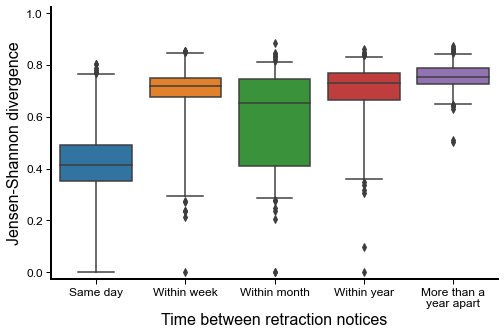

In [261]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()

sns.boxplot(data=result_df_slice, x='class', y='js_div', 
            order=['Same day', 'Within week', 'Within month', 'Within year', 'More than a\nyear apart'], 
            ax=ax, whis=[2.5,97.5], zorder=30)
ax.set_ylabel('Jensen-Shannon divergence', fontsize=16)
ax.set_xlabel('Time between retraction notices', fontsize=16)

ax.tick_params(width=1, length=5, which='major')
ax.tick_params(width=1, length=2, which='minor')
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
ax.set_ylim([-0.025,1.025])

fig.savefig('../img/240405_plos_one_retraction_notice_similarity.png', dpi=200, bbox_inches='tight')

In [232]:
def ast_str(p):
    ast_str = ''
    if p < 0.05:
        ast_str += '*'
    if p < 0.01:
        ast_str += '*'
    if p < 0.001:
        ast_str += '*'
        
    if ast_str == '':
        ast_str = 'n.s.'
    return ast_str

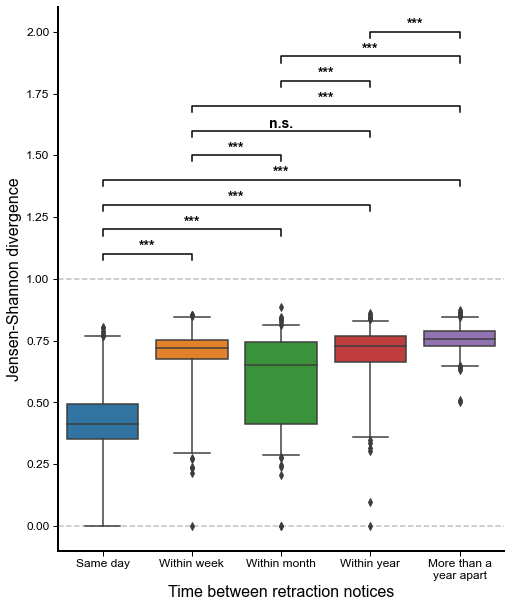

In [262]:
fig = plt.figure(figsize=(8,10))
ax = plt.gca()
labels = ['Same day', 'Within week', 'Within month', 'Within year', 'More than a\nyear apart']

sns.boxplot(data=result_df_slice, x='class', y='js_div', 
            order=labels, 
            ax=ax, whis=[2.5,97.5], zorder=30)
ax.set_ylabel('Jensen-Shannon divergence', fontsize=16)
ax.set_xlabel('Time between retraction notices', fontsize=16)

ax.tick_params(width=1, length=5, which='major')
ax.tick_params(width=1, length=2, which='minor')
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
#ax.set_ylim([-0.025,1.025])
ax.axhline(0, color='k', alpha=0.25, zorder=-10, linestyle='dashed')
ax.axhline(1, color='k', alpha=0.25, zorder=-10, linestyle='dashed')

mult = 0.1
overcount = 0
a_count = 0
for label_1 in labels:
    b_count = 0
    for label_2 in labels:
        if a_count < b_count:
            stat, p = scipy.stats.mannwhitneyu(result_df_slice[result_df_slice['class'] == label_1]['js_div'].values,
                                               result_df_slice[result_df_slice['class'] == label_2]['js_div'].values,
                                               alternative='two-sided')
            ax.text(x=(a_count + b_count)/2, 
                        y=1.1+overcount*mult, 
                        s=ast_str(p), 
                        fontsize=14, va='bottom', ha='center', rotation=0, weight='bold')
                
            ax.plot([a_count,a_count, b_count, b_count], 
                        [1.075+overcount*mult, 1.1+overcount*mult, 1.1+overcount*mult, 1.075+overcount*mult], 
                        lw=1.5, c='k')
            overcount += 1
        b_count += 1
    a_count += 1

fig.savefig('../img/240405_plos_one_retraction_notice_similarity.png', dpi=200, bbox_inches='tight')

Could do for Hindawi, but many of the retraction notices at Hindawi are exactly identical:

https://www.hindawi.com/journals/jeph/2023/9893246/